# Test of the diffusion filter on GRACE data

This notebook provides an example of application of a diffusion filter as described in:
"Mass conserving filter based on diffusion for Gravity Recovery and Climate 
Experiment (GRACE) spherical harmonics solutions, O. Goux, J. Pfeffer, A. Blasquez,
 A. T. Weaver, M. Ablain, 2021" (work in progress). 
 It relies on the package diffusion_filter.

## Display
<div class="alert alert-block alert-info">
    
A function 'plot_anomaly' based on maplotlib and basemap is provided.
<div>

In [1]:
import numpy as np
import netCDF4 as nc
import diffusion_filter.diffusion_operators as dif

# Packages required only for plot_anomaly
import matplotlib.pyplot as plt
import matplotlib.colors as col
import mpl_toolkits.basemap as mpb


def plot_anomaly(grid, title):
    plt.figure(figsize=(7,5), dpi= 100, facecolor='w', edgecolor='k')
    #Create a Basemap object
    m = mpb.Basemap(projection='robin', llcrnrlat=-90, urcrnrlat=90,\
                llcrnrlon=-180, urcrnrlon=180, resolution='c', lon_0=0)
            
    # Transforms lat/lon into plotting coordinates for projection
    lon2D,lat2D=np.meshgrid(np.arange(-179.5,180), np.arange(-89.5,90))
    plon,plat = m(lon2D[:,:],lat2D[:,:]) 
        
    #Add coastlines and boundary
    m.drawcoastlines(linewidth=0.5)
    m.drawmapboundary()
    vmin, vmax = np.percentile( grid.compressed(), [0.01, 100 - 0.01])
    vabs = max([-vmin, vmax])
    cs = m.pcolor(plon, plat, np.roll(grid, grid.shape[1]//2, axis =1),
                  cmap = plt.cm.bwr, shading='auto', 
                  norm = col.SymLogNorm(linthresh = 0.1,
                                        vmin = -vabs, vmax = vabs))
    plt.colorbar(cs, orientation = 'horizontal')
    plt.suptitle(title)

## Test data
<div class="alert alert-block alert-info">
    
The file test_data.netCDF contains two variables: 
- 'ewh' contains a map of Equivalent Water Height anomaly. It has been obtained by projecting on a 1° by 1° grid Level 2 Stokes coefficients from the JPL. The coefficients of degree 1 and the C20 have been replaced. The GIA has been removed and the GAB restores. For more details, see Section 2 in Goux et al.
- 'water_ratio' stores the ratio of ocean surface of each grid cell on a 1° by 1° grid
<div> 

/tmp/ipykernel_5868/3843006899.py:26: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  cs = m.pcolor(plon, plat, np.roll(grid, grid.shape[1]//2, axis =1), cmap = plt.cm.bwr,


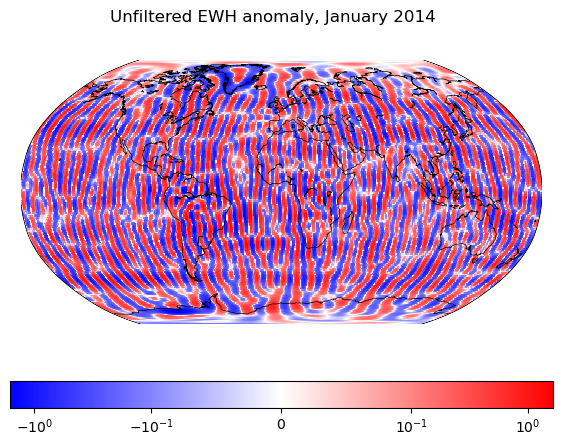

In [2]:
with nc.Dataset("test_data.nc", 'r') as data:
    ewh = data['ewh'][:]
    water_ratio = data['water_ratio'][:]

plot_anomaly(ewh, "Unfiltered EWH anomaly, January 2014")

    
    

## Land/sea mask
<div class="alert alert-block alert-info">
    
In order to define coastlines when using the filter, a land/sea mask is deduced from the water ratio.
<div>

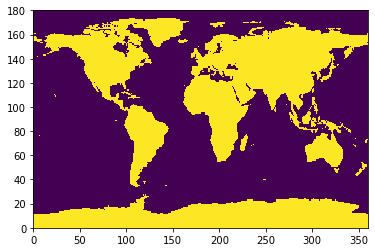

In [3]:
mask = water_ratio<=0.9
#mask = water_ratio<=0.02
plt.pcolor(np.roll(mask, mask.shape[1]//2, axis =1))

## Parameters of the filter
The possible parameters for the function diffusion_filter are presented here. Let $n_{lat}$ and $n_{lon}$ denote the number of points along the latitude and longitude directions.

### input_grid
<div class="alert alert-block alert-info">
    
Masked arrays of gridded values to filter. If input_grid is two-dimensional, its dimensions must be ($n_{lat}$, $n_{lon}$). It can also be three-dimensional to vectorize computations on $N$ grids of the same dimension (typically a time serie but not necessarily). Then its dimensions must be ($N$, $n_{lat}$, $n_{lon}$). If the arrays has a mask , it is merged with out_of_domain_mask.
<div>

### $D$
<div class="alert alert-block alert-info">
    
The Daley length scale $D$ can take a different values on each grid edge. It can be represented as a tuple of two arrays. The first corresponds to the length scales around the North-South direction, which are defined on every parallel arc. Its dimensions are thus ($n_{lat}+1$, $n_{lon}$). The second corresponds to the length scales around the East-West direction, which are defined on every meridian arc. Its dimensions are thus ($n_{lat}$, $n_{lon}+1$). In practice, simpler formats than a tuple of arrays are possible for the filter for the convenience of the user. If $D$ is:
- a scalar, then the length scale is assumed to be uniforme and isotropic.
- a tuple of two scalars, then the length scales are assumed to be uniform ( $D = (D_{NS}, D_{EW})$ )
- a tuple of four scalars, then the first two length scales are applied on the ocean, the last two on land ($D = (D^{ocean}_{NS}, D^{ocean}_{EW}, D^{land}_{NS}, D^{land}_{EW})$).

If a fully variable field is provided, the function might modify it to ensure that it is consistent with the boundary conditions (\textit{e.g.} that the first and last column of D_{EW} are equal to enforce periodicity.). $D$ should be
given in meters.
<div>
    

### $M$
<div class="alert alert-block alert-info">
    
The shape parameter $M$ must be an integer strictly superior to two. The larger $M$ is, the sharper the cut-off of the filter is.
<div>
    

### water_ratio
<div class="alert alert-block alert-info">

(Optional) Array of dimensions ($n_{lat}$, $n_{lon}$) of the ratio of ocean surface of each grid cell. If provided it is used to ponderate mixed land/water grid cells.
<div>
    

### boundary_mask
<div class="alert alert-block alert-info">

(Optional) Boolean mask of dimensions ($n_{lat}$, $n_{lon}$). If a mask is provided through this argument, a boundary condition is used to prevent any flux between masked and non-masked data, while filtering both areas. For example if a land mask is provided, there will be no flux through coastlines and the land and ocean signals will be filtered independently. This argument also determines where each length scale is used if a tuple of four elements is provided for $D$.
<div>
    

### out_of_domain_mask
<div class="alert alert-block alert-info">

(Optional) Boolean mask of dimensions ($n_{lat}$, $n_{lon}$). If a mask is provided through this argument, a boundary condition is used to prevent any flux between masked and non-masked data, and the mask data will not be processed. For example if a land mask is provided, only the ocean signal will be filtered and the land signal will be masked.
<div>
    

### surface_model
<div class="alert alert-block alert-info">

(Optional) String equal to 'sphere' or 'ellipsoid' (the default). Model used for the shape of the surface on which the grid lie.
<div>
    

### boundary_inflation_factor
<div class="alert alert-block alert-info">
    
(Optional) Scalar used to tune the amplitude of the local inflation of the length scale near coastlines ($\alpha$ in Equation 14 of Goux et al.). For no inflation, set it to zero. Defaults to 1.
<div>
    

### boundary_inflation_range
<div class="alert alert-block alert-info">
    
(Optional) Scalar used to tune the width of the local inflation of the length scale near coastlines ($\beta$ in Equation 14 of Goux et al.). Defaults to 1.
<div>

### latitude_variability
<div class="alert alert-block alert-info">
    
(Optional) Tuple of scalars used to increase the Daley length scale as a cosine of latitude. The first scalar affects the meridional length scales, the second scalar affects the zonal length scales. If a scalar is equal to 1, the correpsonding length scales are doubled at the equator, if it is equal they are unaffected. The length scales at the poles are always unaffected. Defaults to (0, 0)
<div>

## Application
<div class="alert alert-block alert-info">
    
The filter is applied to a monthly EWH anomaly from 2014. The land mask is given as a 'boundary_mask' argument, which means there is a restriction on flux through. The mask also determines where each lengh scale is applied: the first two elements of the tuple are applied outside the mask on the ocean; the last two elements are applied inside the mask on land.
<div>

/tmp/ipykernel_5868/3843006899.py:26: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  cs = m.pcolor(plon, plat, np.roll(grid, grid.shape[1]//2, axis =1), cmap = plt.cm.bwr,


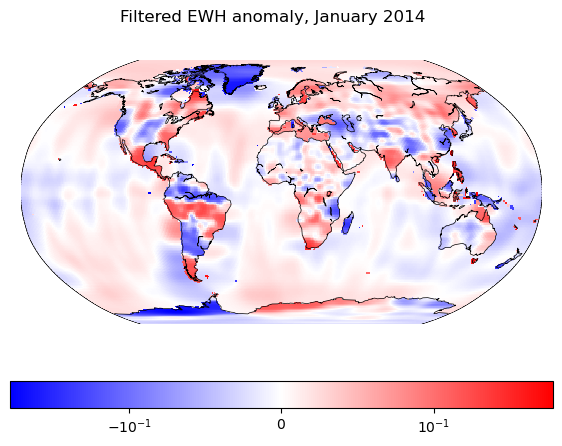

In [4]:


D = (360E3, 540E3, 150E3, 330E3)
M = 4


filtered_ewh = dif.diffusion_filter(ewh, D, M,
                                    water_ratio = water_ratio,
                                    boundary_mask = mask)

plot_anomaly(filtered_ewh, "Filtered EWH anomaly, January 2014")

On the other hand, if we are only interested by data on the ocean, or if we don't have data on land, then the maks can be supplied through the argument 'out_of_domain_mask'.

/tmp/ipykernel_5868/3843006899.py:26: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  cs = m.pcolor(plon, plat, np.roll(grid, grid.shape[1]//2, axis =1), cmap = plt.cm.bwr,


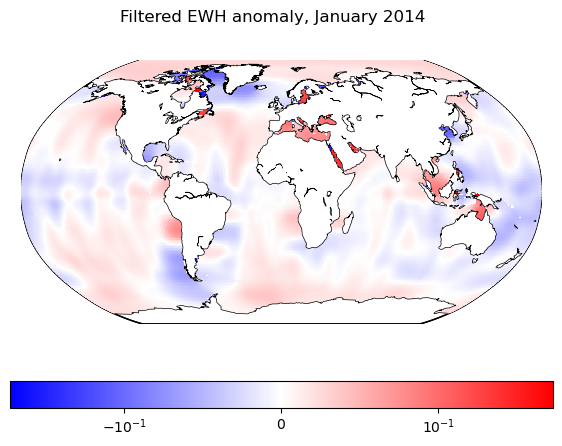

In [5]:
D = (360E3, 540E3, 150E3, 330E3)
M = 4


filtered_ewh = dif.diffusion_filter(ewh, D, M, 
                                    water_ratio = water_ratio,
                                    out_of_domain_mask = mask)

plot_anomaly(filtered_ewh, "Filtered EWH anomaly, January 2014")

The solution B of the associated article provides a good compromise between preservation of the signal and noise damping for maps of linear trends, uses the parameters:


/tmp/ipykernel_5868/3843006899.py:26: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  cs = m.pcolor(plon, plat, np.roll(grid, grid.shape[1]//2, axis =1), cmap = plt.cm.bwr,


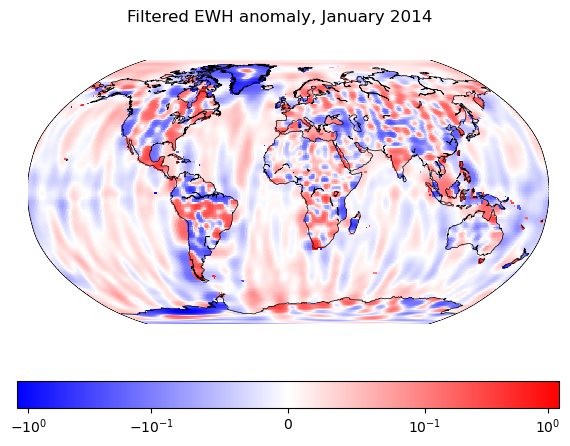

In [15]:

D = (170E3, # Along North-South direction on the ocean
     220E3, # Along East-West direction on the ocean
     50E3, # Along North-South direction on land
     150E3) # Along North-South direction on land
M = 8



# Filter the solution
filtered_ewh = dif.diffusion_filter(ewh, D, M,
                                    water_ratio = water_ratio,
                                    boundary_mask = mask,
                                    boundary_inflation_factor =1 ,
                                    boundary_inflation_range=1,
                                    latitude_variability = (1,1))
plot_anomaly(filtered_ewh, "Filtered EWH anomaly, January 2014")

Recovering a linear trend from a time serie eliminates some noise, so a slightly higher level of filtering to match the lower signal-to-noise ratio might be more appropriate to observe a single element of this time serie. In this exampe is is done by increasing the latitude variability in the zonal direction (e.g. increasing the length scales on the East-West direction at low latitudes in particular).

/tmp/ipykernel_5868/3843006899.py:26: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  cs = m.pcolor(plon, plat, np.roll(grid, grid.shape[1]//2, axis =1), cmap = plt.cm.bwr,


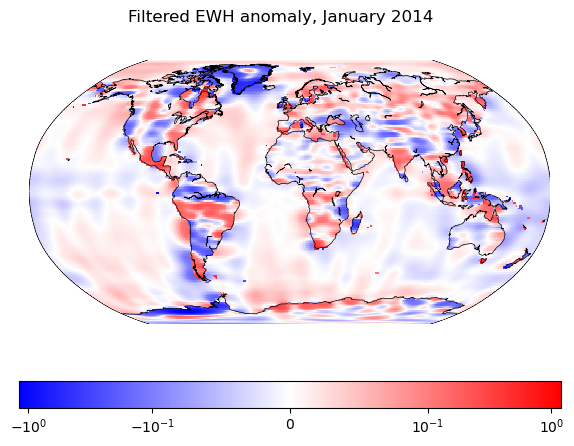

In [17]:

D = (170E3, # Along North-South direction on the ocean
     220E3, # Along East-West direction on the ocean
     50E3, # Along North-South direction on land
     150E3) # Along North-South direction on land
M = 8



# Filter the solution
filtered_ewh = dif.diffusion_filter(ewh, D, M,
                                    water_ratio = water_ratio,
                                    boundary_mask = mask,
                                    boundary_inflation_factor =0 ,
                                    boundary_inflation_range=1,
                                    latitude_variability = (1,2))
plot_anomaly(filtered_ewh, "Filtered EWH anomaly, January 2014")